In [1]:
from transformers import AutoProcessor, AutoModelForCausalLM  
from PIL import Image
import requests
import copy
import os

/home/gsfc-pi/dev/florence-test/.florence/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from unittest.mock import patch
from transformers.dynamic_module_utils import get_imports

def fixed_get_imports(filename: str | os.PathLike) -> list[str]:
    if not str(filename).endswith("modeling_florence2.py"):
        return get_imports(filename)
    imports = get_imports(filename)
    imports.remove("flash_attn")
    return imports

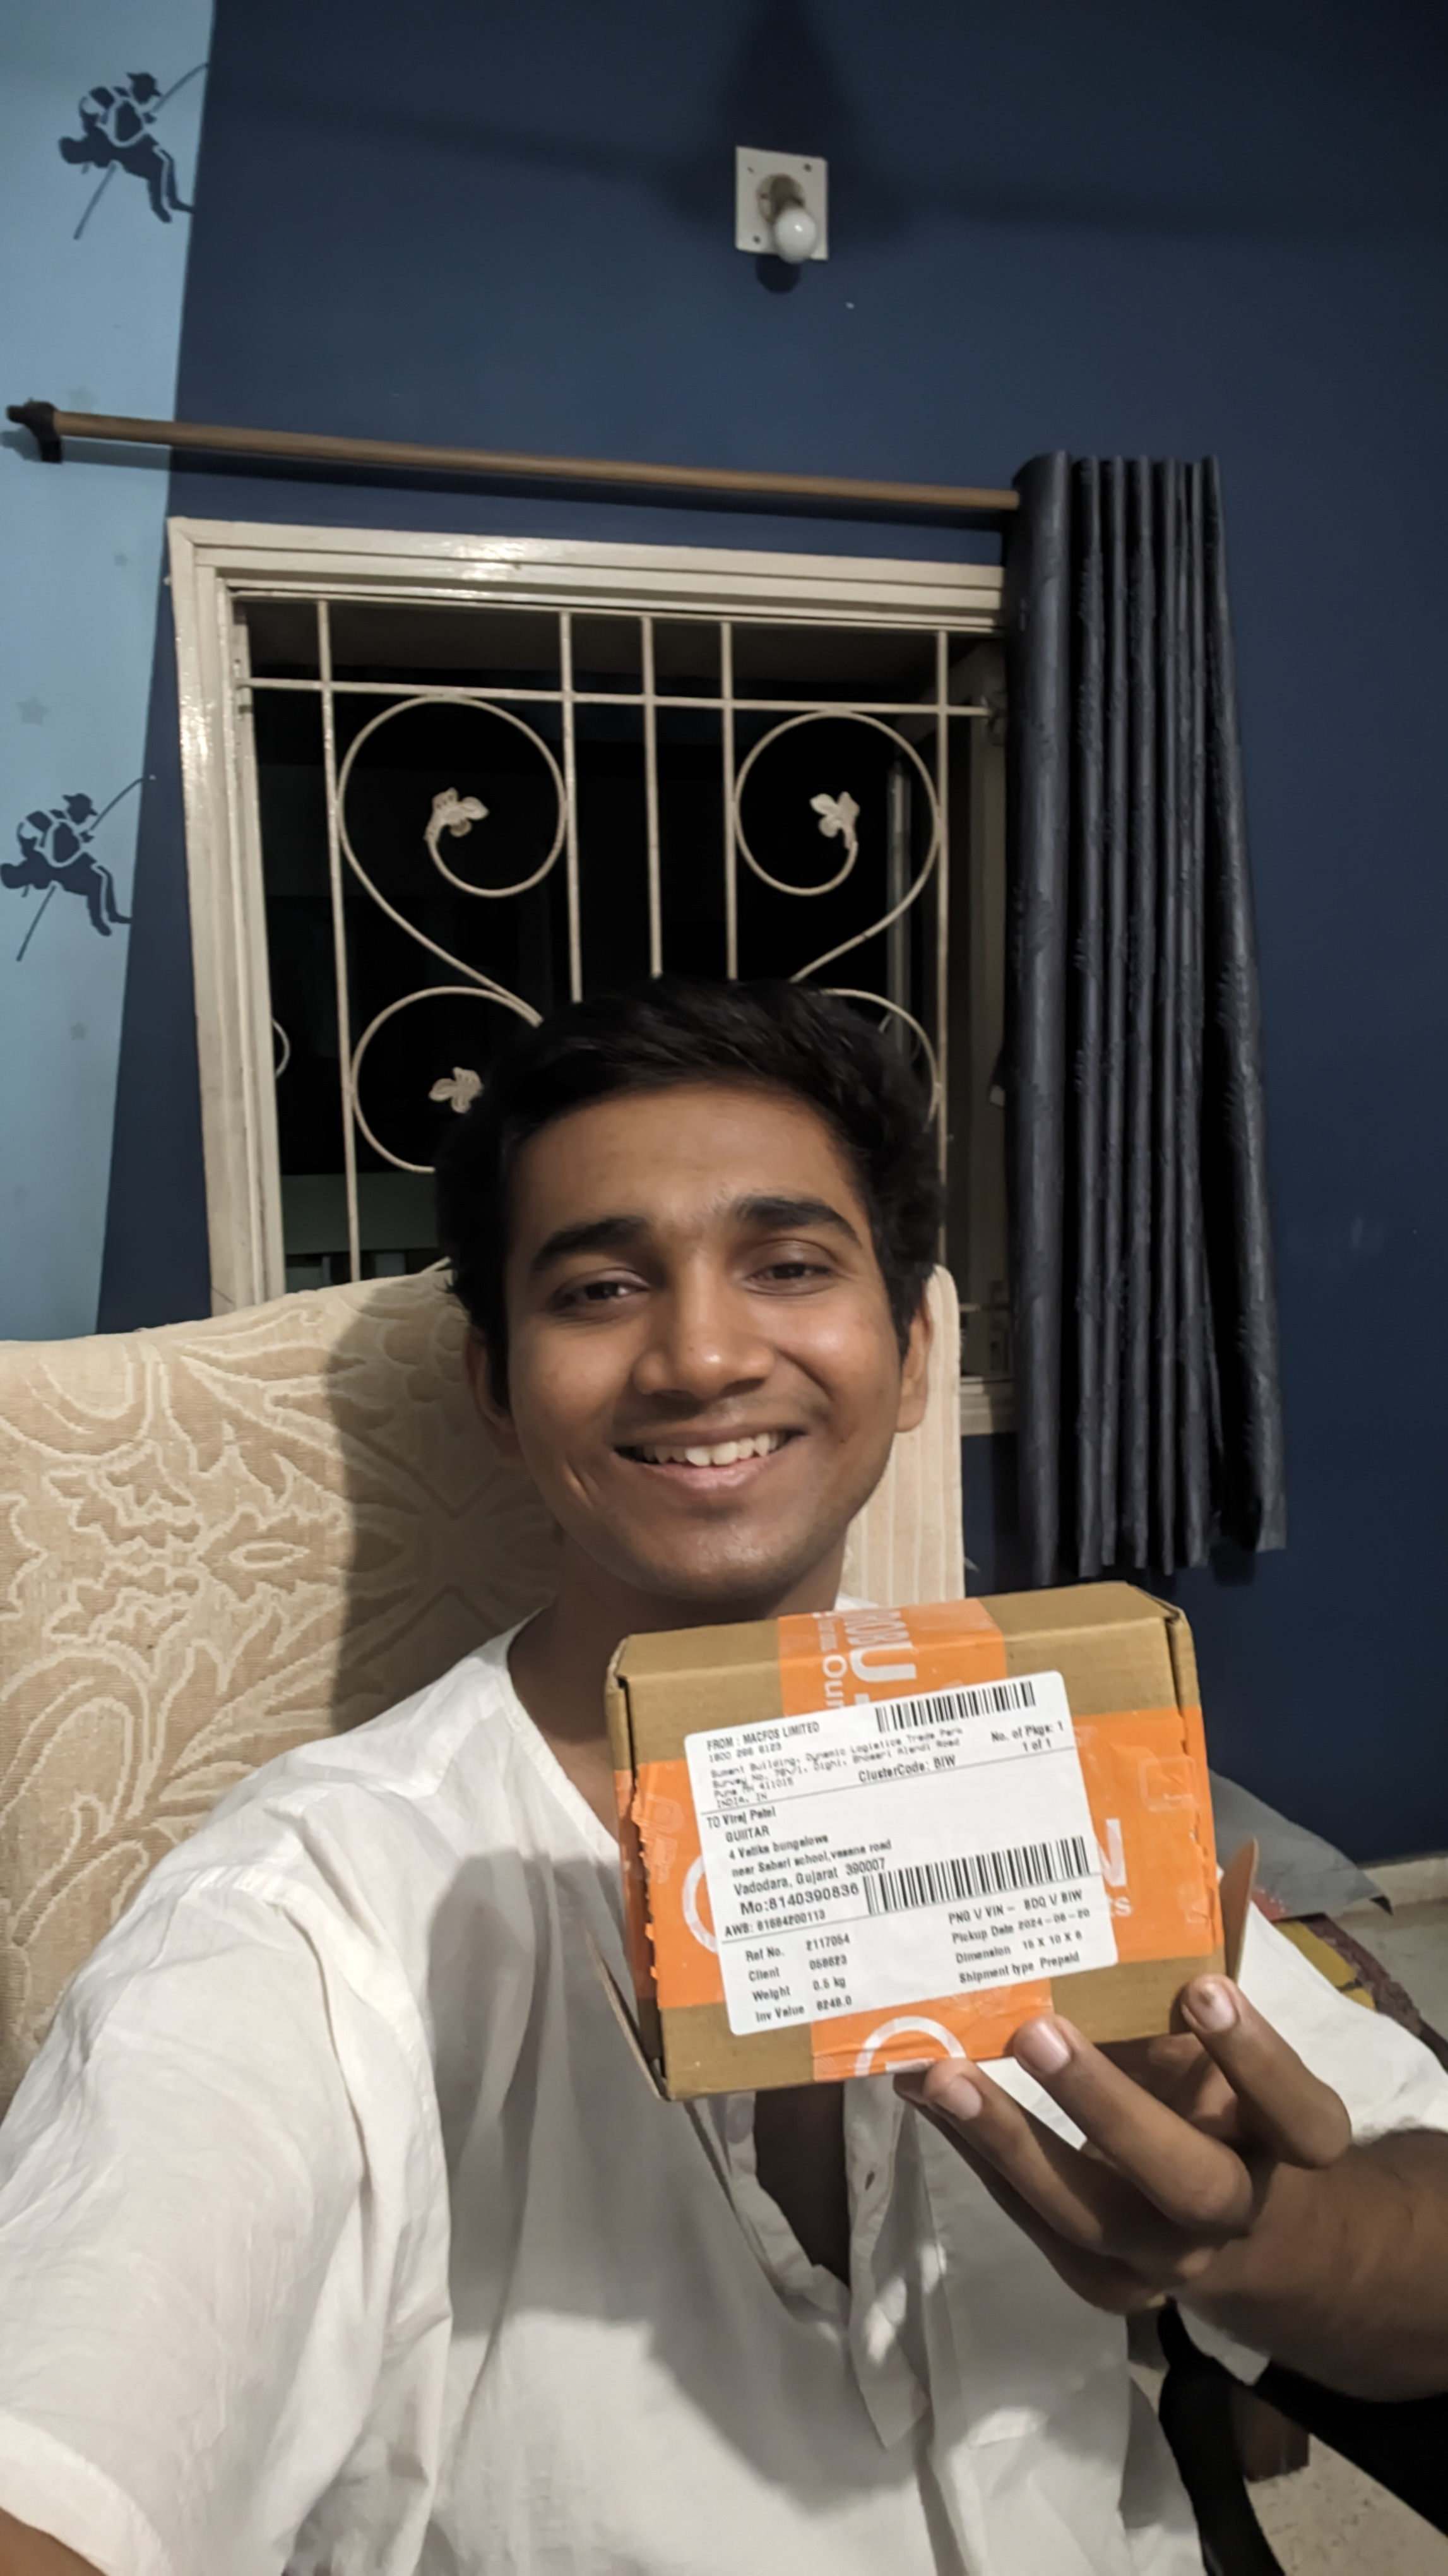

In [3]:
image = Image.open("/home/gsfc-pi/dev/media/selfie_new.jpeg")

image

In [4]:
with patch("transformers.dynamic_module_utils.get_imports", fixed_get_imports): #workaround for unnecessary flash_attn requirement
    model_id = 'microsoft/Florence-2-base'
    model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True).eval()
    processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

In [7]:
def run_example(task_prompt, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt")
    generated_ids = model.generate(
      input_ids=inputs["input_ids"],
      pixel_values=inputs["pixel_values"],
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text, 
        task=task_prompt, 
        image_size=(image.width, image.height)
    )

    return parsed_answer

In [8]:
task_prompt = '<DETAILED_CAPTION>'
run_example(task_prompt)

{'<DETAILED_CAPTION>': 'The image shows a man sitting on a couch, holding a box in his hands with a smile on his face. In the background, there is a wall with a window and a curtain.'}